# TRABAJO PRÁCTICO 3 - Regresión Logística.

In [46]:
#Librerías

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist


##### Exploración de datos

shape: entrenamiento 	 X: (60000, 28, 28) 	 Y: (60000,)
shape: test 	 X: (10000, 28, 28) 	 Y: (10000,)


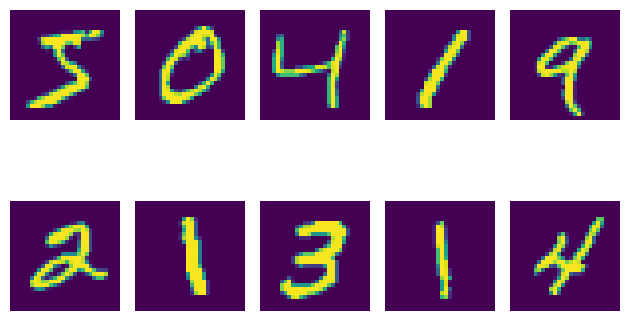

In [47]:
(x_train, y_train), (x_test, y_test) = mnist.load_data ()

print('shape: entrenamiento','\t X:', x_train.shape, '\t Y:',y_train.shape)
print('shape: test','\t X:', x_test.shape, '\t Y:',y_test.shape)

for i in np.arange(0,10,1):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[i])
    plt.axis("off")
plt.tight_layout()

#S1 -> impares  y 0 -> pares
categorical_train = y_train %2
categorical_test = y_test %2

# Preprocesamiento

In [48]:
class Normalizar : 
    def __init__ (self):
        self.mean = None
        self.var = None
    
    def fit(self, X):
        self.mean = np.zeros((X.shape[1], X.shape[2]))
        self.var = np.zeros((X.shape[1], X.shape[2]))

        for i in range (X.shape[1]):
            for j in range (X.shape[2]):
                self.mean[i,j] = np.mean(X[:,i,j])  #Se calcula la media del mismo pixel en todas las img
                self.var[i,j] = np.var(X[:,i,j]) #Se calcula la varianza del mismo pixel en todas las img
        
    def transform(self, X):
        X_c = np.copy(X) #Se genera una copia para no modificar los datos originales
        X_c = X_c.reshape(X_c.shape[0],-1) #Se cambia el tamaño para tener un array de 60k x 784
        var_reshaped = self.var.reshape(-1) #Se arma la fila de 784 elementos a partir del 28x28
        mean_reshaped = self.mean.reshape(-1) #Se arma la fila de 784 elementos a partir del 28x28

        for i in range(var_reshaped.shape[0]): #Se recorre todo el array de varianzas
            if(var_reshaped[i] > 0 ): #Si la varianza no es nula
                X_c[:,i] = (X_c[:,i] - mean_reshaped[i]) / np.sqrt(var_reshaped[i]) #Normalizar
        
        filter = (var_reshaped != 0)
        return X_c[:,filter] #Se aplica el filtro a las 60k img y se guarda en el dataset inicial

    def fit_transform(self, X):
        self.fit(self,X)
        return self.transform(self,X)


In [ ]:
#Testing
norm = Normalizar()

norm.fit(x_train)

data = norm.transform(x_train)


data = norm.fit_transform(x_train)










TypeError: Normalizar.fit() takes 2 positional arguments but 3 were given